In [1]:
import pandas as pd
from IPython.core.display import HTML
from IPython.core.display import Image 
%load_ext music21.ipython21.ipExtension
import numpy as np
import music21 as mu
import pymongo
%pylab inline
from pymongo import MongoClient
from bs4 import BeautifulSoup
import re
import pydash as py_
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
import math
import music21 as mu
from functools import partial

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)


Populating the interactive namespace from numpy and matplotlib


In [2]:
muAutumnLeaves = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJAutumnLeaves1996_1371_192.xml')
muStellaByStarlight = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJStellaByStarlight1983_1534_161.xml')
muGroovinHigh = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJGroovinHigh1999_1996_290.xml')
muAllTheThingsYouAre = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJAllTheThingsYouAre1983_2143_290.xml')
muIfIWereABell = mu.converter.parse('FinalDataSet/XMLFiles/JazzSolos/KJIfIWereABell2002_2161_227.xml')

In [3]:
def cleanAccidental(data_row):
    accidentalString = str(data_row['accidental'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 

def cleanNoteName(data_row):
    accidentalString = str(data_row['noteName'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 

def cleanOctave(data_row):
    accidentalString = str(data_row['octave'])
    test = re.sub('<[^>]*>', '', accidentalString)
    return str(test) 

def cleanRest(data_row):
    restVal = -1
    restAsString = str(data_row['restFlag'])
    if restAsString != 'None':
        restVal ='rest'
    else:
        restVal = 'note'

    return str(restVal)

def cleanPart(data_row):
    accidentalString = str(data_row['instrument'])
    test = accidentalString[3:5]
    return str(test) 

def convertDurationAsPerQuarterNoteIsOneBeat(data_row):
    asFloat = float(data_row['duration'])
    asFloat = asFloat / 256
    asFloat = floor(asFloat * 100) / 100.0
    
    return round(asFloat, 2)



def midiNumberAssign(data_row):
    offsetForC = 0
    offsetForD = 2
    offsetForE = 4
    offsetForF = 5
    offsetForG = 7
    offsetForA = 9
    offsetForB = 11

    def adjustForAccidental(accidentalVal):
        if accidentalVal == 'None':
            return 0
        else:
            return int(accidentalVal)

    if data_row['octave'] != "None":
        baseVal = int(data_row['octave']) * 12
        if data_row['noteName'] == 'C':
            return baseVal + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'D':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'E':
            return baseVal + offsetForE + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'F':
            return baseVal + offsetForF + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'G':
            return baseVal + offsetForG + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'A':
            return baseVal + offsetForA + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'B':
            return baseVal + offsetForB + adjustForAccidental(data_row['accidental'])



def adjustForAccidental(accidentalVal):
    if accidentalVal == 'None':
        return 0
    else:
        return int(accidentalVal)

    if data_row['octave'] != "None":
        baseVal = int(data_row['octave']) * 12
        if data_row['noteName'] == 'C':
            return baseVal + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'D':
            return baseVal + offsetForD + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'E':
            return baseVal + offsetForE + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'F':
            return baseVal + offsetForF + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'G':
            return baseVal + offsetForG + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'A':
            return baseVal + offsetForA + adjustForAccidental(data_row['accidental'])
        elif data_row['noteName'] == 'B':
            return baseVal + offsetForB + adjustForAccidental(data_row['accidental'])

def fixTiedNotes(data_row):
    tieFlagString = str(data_row['tieFlag'])
    durationToAdd = -1
    if tieFlagString == '<tie type="stop"></tie>':
        durationToAdd = data_row['quarterNoteDuration']
    else:
        durationToAdd = 0

    return durationToAdd


def getChordRootAsInt(data_row):
    x = data_row['chordDisplayName']
    if x != -1:    
        chordLetterVal = data_row['chordDisplayName'][0:2]
        #print chordLetterVal
        if chordLetterVal.strip() == 'C':
            return 0
        elif chordLetterVal.strip() =='C#':
            return 1
        elif chordLetterVal.strip() == 'Db':
            return 1
        elif chordLetterVal.strip() == 'D':
            return 2
        elif chordLetterVal.strip() == 'D#':
            return 3
        elif chordLetterVal.strip() == 'Eb':
            return 3
        elif chordLetterVal.strip() == 'E':
            return 4
        elif chordLetterVal.strip() == 'F':
            return 5
        elif chordLetterVal.strip() == 'F#':
            return 6
        elif chordLetterVal.strip() == 'Gb':
            return 6
        elif chordLetterVal.strip() == 'G':
            return 7
        elif chordLetterVal.strip() == 'G#':
            return 8
        elif chordLetterVal.strip() == 'Ab':
            return 8
        elif chordLetterVal.strip() == 'A':
            return 9
        elif chordLetterVal.strip() == 'A#':
            return 10
        elif chordLetterVal.strip() == 'Bb':
            return 10
        elif chordLetterVal.strip() == 'B':
            return 11
        else:
            return -1
       


    
def getChordTypeAsInt(data_row):
    x = data_row['chordDisplayName']
    if x != -1:
        #print x
        chordType = re.findall('\s(.*)', x)
        chordType = str(chordType[0])
        if chordType == 'maj7':
            return 0
        elif chordType == 'min7':
            return 1
        elif chordType == 'dom7':
            return 2
        elif chordType == 'dim7':
            return 3
        elif chordType == 'maj7b5':
            return 4
        elif chordType == 'maj7#5':
            return 5
        elif chordType == 'maj7sus4':
            return 6
        elif chordType == 'min7b5':
            return 7
        elif chordType == 'dom7b5':
            return 8
        elif chordType == 'dom7#5':
            return 9
        elif chordType == 'dom7sus4':
            return 10
        
        return chordType


def chordTypeForDisplay(data_row):
    x = data_row['chordDisplayName']
    if x != -1:
        chordType = re.findall('\s(.*)', x)   
        chordType = str(chordType[0])
        return chordType
    
    
def chordBassAsInt(data_row):
    x = data_row['chordDisplayName']
    if x != -1:
        x = str(x)
        indexOfBackslash = x.find('/')
        if indexOfBackslash == -1:
            return -1
        else:
            #function to deal with bass note
            return 'placeholder'
    

def concatenateNoteNamesAndAccidentals(data_row):
    retString = str(data_row['noteName'])
    if data_row['accidental'] == '-1':
        retString = retString + 'b'
    elif data_row['accidental'] == '1':
        retString = retString + '#'
    retString = retString + str(data_row['octave'])
    return retString


def concatenateNoteNamesAndAccidentalsNoOctave(data_row):
    retString = str(data_row['noteName'])
    if data_row['accidental'] == '-1':
        retString = retString + 'b'
    elif data_row['accidental'] == '1':
        retString = retString + '#'

    return retString

def getFloorValueForMeasure(data_row):
    offsetForMeasure = 1
    floorValue = data_row['noteEventStartingLocation']
    floorValue = (floorValue / 4) + offsetForMeasure
    return math.floor(floorValue)


In [4]:
#get next 10 chords
# instrument
class CreateDataSetFromXML:
    def __init__(self, xmlFile="", performerName="", composerName="", 
                 genre="", numberOfParts=-1, title="", yearOfComposition="", 
                 yearOfPerformance="", ongoingTempo=-1, 
                 numberOfQuarterBeatsInBar = -1, tempoChangeIsOccuring = False):
        self.xmlFile = xmlFile
        self.genre = genre
        self.numberOfParts = numberOfParts
        self.parsedXMLData = ""
        self.df = ""
        self.performerName = performerName
        self.composerName = composerName
        self.genre = genre
        self.numberOfParts = numberOfParts
        self.title = title
        self.yearOfComposition = yearOfComposition
        self.yearOfPerformance = yearOfPerformance
        self.ongoingTempo = ongoingTempo
        self.numberOfQuarterBeatsInBar = numberOfQuarterBeatsInBar
        self.tempoChangeIsOccuring = tempoChangeIsOccuring
    

    def convertXMLToDataFrame(self):
        parsedXMLData = BeautifulSoup(open(self.xmlFile))
        allNotes = parsedXMLData.findAll('note')
        listOfNoteEvents = []
        for note in allNotes:
            dictForNoteEvent = {}
            if note.parent.words:
                chord =  str(note.parent.words.text)
            else:
                chord = -1
            dictForNoteEvent['chordDisplayName'] = chord
            dictForNoteEvent['restFlag'] = note.rest
            dictForNoteEvent['noteName'] = note.step
            dictForNoteEvent['octave'] = note.octave
            dictForNoteEvent['duration'] = note.duration.text
            dictForNoteEvent['instrument'] = note.instrument.attrs.values()
            dictForNoteEvent['accidental'] = note.alter
            dictForNoteEvent['tieFlag'] = str(note.tie)

            listOfNoteEvents.append(dictForNoteEvent)
        self.parsedXMLData = listOfNoteEvents
        self.df = pd.DataFrame(self.parsedXMLData)
        
    def cleanDataFrame(self):
        '''initial clean of dataframe'''
        self.df['performerName'] = self.performerName
        self.df['composerName'] = self.composerName
        self.df['genre'] = self.genre
        self.df['numberOfParts'] = self.numberOfParts
        self.df['title'] = self.title
        self.df['yearOfComposition'] = self.yearOfComposition
        self.df['yearOfPerformance'] = self.yearOfPerformance
        self.df['ongoingTempo'] = self.ongoingTempo
        self.df['title'] = self.title
        self.df['accidental'] = self.df.apply(cleanAccidental, axis=1) 
        self.df['noteName'] = self.df.apply(cleanNoteName, axis=1) 
        self.df['octave'] = self.df.apply(cleanOctave, axis=1) 
        self.df['restFlag'] = self.df.apply(cleanRest, axis=1)
        self.df['part'] = self.df.apply(cleanPart, axis=1)
        self.df['quarterNoteDuration'] = self.df.apply(convertDurationAsPerQuarterNoteIsOneBeat, axis=1)
        self.df['midiNumber'] = self.df.apply(midiNumberAssign, axis=1)
        self.df['valueToAddToTiedNote']=self.df.apply(fixTiedNotes, axis=1)
        self.df['noteDisplayName'] = self.df.apply(concatenateNoteNamesAndAccidentals, axis=1)
        self.df['noteDisplayNameNoOctave'] = self.df.apply(concatenateNoteNamesAndAccidentalsNoOctave, axis=1)
        self.df['moveTieForFix'] = self.df['valueToAddToTiedNote'].shift(-1)
        self.df = self.df[self.df.tieFlag != '<tie type="stop"></tie>']
        self.df['updatedQuarterNoteDuration'] = self.df['quarterNoteDuration'] + self.df['moveTieForFix']
        self.df['quarterNoteDuration'] = self.df['updatedQuarterNoteDuration']
        self.df['nextNoteFreqDistance'] = self.df['midiNumber'].shift(-1)
        self.df['nextNoteFreqDistance'] = self.df['nextNoteFreqDistance'] - self.df['midiNumber']


        
    def fixLocation(self):
        pianoPart = self.df[self.df['part'] == 'P1']
        bassPart = self.df[self.df['part'] == 'P2']
        pianoPart['noteEventLocation'] = pianoPart['quarterNoteDuration'].cumsum()
        bassPart['noteEventLocation'] = bassPart['quarterNoteDuration'].cumsum()
        pianoPart['noteEventStartingLocation'] = pianoPart['noteEventLocation'].shift()
        bassPart['noteEventStartingLocation'] = bassPart['noteEventLocation'].shift()


        #display(HTML(bassPart[0:100].to_html()))
        self.df = pd.concat([pianoPart, bassPart], axis=0)
        self.df['noteEventStartingLocation'].fillna(0.0, inplace=True)
        self.df['measure'] = self.df.apply(getFloorValueForMeasure, axis=1)
        self.df = self.df.sort(['noteEventStartingLocation', 'part'], ascending=[1,0])
        
        self.df = self.df.reset_index(drop=True)



    def updateChordNumericalData(self):
        self.df['chordRootAsInt'] = self.df.apply(getChordRootAsInt, axis=1)
        self.df['chordTypeAsInt'] = self.df.apply(getChordTypeAsInt, axis=1)
        self.df['chordBassAsInt'] = self.df.apply(chordBassAsInt, axis=1)
        self.df['chordTypeDisplay'] = self.df.apply(chordTypeForDisplay, axis=1)
        self.df['chordTypeDisplay'].fillna(method='ffill', inplace=True)
        
        
    def fillChordVals(self):
        self.df['chordDisplayName'].replace(-1, np.nan, inplace = True)
        self.df['chordDisplayName'].fillna(method='ffill', inplace=True)

    
    def removeUnusedColumns(self):
        del self.df['tieFlag']
        del self.df['valueToAddToTiedNote']
        del self.df['moveTieForFix']
        del self.df['accidental']
        del self.df['noteName']
        del self.df['octave']
        del self.df['updatedQuarterNoteDuration']
        del self.df['instrument']
        del self.df['duration']


    def returnPreparedDataFrame(self):
        return self.df
        

<h2>Data Preparation</h2>

In [5]:
stellaData = CreateDataSetFromXML(xmlFile="FinalDataSet/XMLFiles/JazzSolos/KJStellaByStarlight1983_1534_161.xml", 
                                  performerName="Keith Jarrett", composerName="Victor Young", genre="jazz", 
                                  numberOfParts=2, title="Stella By Starlight", 
                                  yearOfComposition="1943", yearOfPerformance="1983", 
                                  ongoingTempo=120, 
                                  numberOfQuarterBeatsInBar=4, tempoChangeIsOccuring = False)
stellaData.convertXMLToDataFrame()
stellaData.cleanDataFrame()
stellaData.fixLocation()
stellaData.updateChordNumericalData()
stellaData.removeUnusedColumns()
stellaData.fillChordVals()
stellaDf = stellaData.returnPreparedDataFrame()

In [6]:
#stellaDf.head(5)

In [7]:
groovinData = CreateDataSetFromXML(xmlFile="FinalDataSet/XMLFiles/JazzSolos/KJGroovinHigh1999_1996_290.xml", 
                                  performerName="Keith Jarrett", composerName="Dizzy Gillespie", genre="jazz", 
                                  numberOfParts=2, title="Groovin High", 
                                  yearOfComposition="1943", yearOfPerformance="1999", 
                                  ongoingTempo=120, 
                                  numberOfQuarterBeatsInBar=4, tempoChangeIsOccuring = False)
groovinData.convertXMLToDataFrame()
groovinData.cleanDataFrame()
groovinData.fixLocation()
groovinData.updateChordNumericalData()
groovinData.removeUnusedColumns()
groovinData.fillChordVals()
groovinDf = groovinData.returnPreparedDataFrame()

In [8]:
autumnData = CreateDataSetFromXML(xmlFile="FinalDataSet/XMLFiles/JazzSolos/KJAutumnLeaves1996_1371_192.xml", 
                                  performerName="Keith Jarrett", composerName="Joseph Kosma", genre="jazz", 
                                  numberOfParts=2, title="Autumn Leaves", 
                                  yearOfComposition="1943", yearOfPerformance="2002", 
                                  ongoingTempo=120, 
                                  numberOfQuarterBeatsInBar=4, tempoChangeIsOccuring = False)
autumnData.convertXMLToDataFrame()
autumnData.cleanDataFrame()
autumnData.fixLocation()
autumnData.updateChordNumericalData()
autumnData.removeUnusedColumns()
autumnData.fillChordVals()
autumnDf = autumnData.returnPreparedDataFrame()

In [9]:
ifIWereData = CreateDataSetFromXML(xmlFile="FinalDataSet/XMLFiles/JazzSolos/KJIfIWereABell2002_2161_227.xml", 
                                  performerName="Keith Jarrett", composerName="Frank Loesser", genre="jazz", 
                                  numberOfParts=2, title="If I Were A Bell", 
                                  yearOfComposition="1943", yearOfPerformance="1999", 
                                  ongoingTempo=120, 
                                  numberOfQuarterBeatsInBar=4, tempoChangeIsOccuring = False)
ifIWereData.convertXMLToDataFrame()
ifIWereData.cleanDataFrame()
ifIWereData.fixLocation()
ifIWereData.updateChordNumericalData()
ifIWereData.removeUnusedColumns()
ifIWereData.fillChordVals()
ifIWereDf = ifIWereData.returnPreparedDataFrame()

In [10]:
allTheThingsData = CreateDataSetFromXML(xmlFile="FinalDataSet/XMLFiles/JazzSolos/KJAllTheThingsYouAre1983_2143_290.xml", 
                                  performerName="Keith Jarrett", composerName="Someone", genre="jazz", 
                                  numberOfParts=2, title="All The Things You Are", 
                                  yearOfComposition="1943", yearOfPerformance="1983", 
                                  ongoingTempo=120, tempoChangeIsOccuring = False)
allTheThingsData.convertXMLToDataFrame()
allTheThingsData.cleanDataFrame()
allTheThingsData.fixLocation()
allTheThingsData.updateChordNumericalData()
allTheThingsData.removeUnusedColumns()
allTheThingsData.fillChordVals()
allTheThingsDf = allTheThingsData.returnPreparedDataFrame()

In [11]:
df = pd.concat([stellaDf, groovinDf, autumnDf, ifIWereDf, allTheThingsDf], axis=0)
#df = stellaDf

In [12]:
#df.tail(500)

In [13]:
df['title'].value_counts()

If I Were A Bell          2628
All The Things You Are    2375
Groovin High              2118
Stella By Starlight       1801
Autumn Leaves             1461
dtype: int64

In [14]:
#df['accidental'].value_counts()

<h3>Chapter 4 - An analysis of melody</h3>

<br>
<ol>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#someGeneralCharacteristics">Some General Characteristics</a></li>
<li><a href="#phraseLength">Phrase Length</a></li>
<li><a href="#microphrase">Commonly used patterns within phrases</a></li>
<li><a href="#keySignature">The influence of key signature</a></li>
<li><a href="#repetitionAndSequences">Repetition and sequences</a></li>
<li><a href="#rhythm">The use of rhythm</a></li>
<li><a href="#contour">Melodic contours</a></li>
<li><a href="#tempo">The influence of tempo</a></li>
<li><a href="#timeSignaure">The influence of time signature</a></li>
<li><a href="#songLocation">How melodic phrases are affected by the place they occur</a></li>

</ol>



<h4><a id="introduction">Introduction</a></h4>
<div>
    The following two chapters will undertake a data driven analysis of 10 Keith Jarrett solos. The first of the chapters will cover questions regarding melody and rhythm. Melody and Rhythm, often regarded as seperate components have here been covered together, as a case can be made that there are interdependcies betwen them. What is the data revealing about jazz improvisation practice
</div>
<div>
    it is difficult ot differentiate rhtymic devices from melodic devicies so they will be dealt with together. The previous chapters have emphasised that this data driven, so no assumptions, but the practical usefulness of the findings are aimed at according with the findings of the previous chapter. If trying to dervice rules, are there certain types of things that can be - rules....The kinds of questions that can be asked explore typical happen in jazz, questions of taste. How long should and improvised phrase be? Is there an ideal length and does this change depending on the tempo and chord progression? Is key a factor? Do different tonal centres tend to lead toward different used, registers. Does the length of prhase change over time. Is Keith Jarrett's development moving towards a particular type of phrases. The main concerns of jazz music outlined in the previous chapters are drivers for the kinds of questions that are being asked
</div>

In [15]:
soloMetaData = pd.read_csv('miscData/soloMetaData.csv')

In [16]:
soloMetaData

,Title,Year Recorded,Key Signature,Tempo of this perf,Time Signature,Length
0,Stella By Starlight,1983,Bb Major,220,4/4.,296
1,Groovin High,1999,Eb Major,180,4/4.,189
2,If I Were A Bell,2002,Ab Major,178,4/4.,187
3,Autumn Leaves,1996,G minor,200,4/4.,200
4,All The Things You Are,1983,Ab Major,120,4/4.,300


<p>'Here's Miles,"[Wynton Marsalis says and sings a phrase by Miles Davis].  "I would say, "Damn, why did he play like that? Here's 'Trane [Marsalis sings a passage by John Coltrane]. "Trane's playing just the exact opposite. Why is 'Trane playing like that? When you are just learning jazz, everything is mystical"(Berliner, 34).</p>  <p>This quote above is taken from the opening pages of Peter Berliner's landmark study on jazz improvisation and highlights the critical problem of jazz improvisation: it is not clear what jazz improvisation really is. When musicians improvise in jazz, on some level decisions are being taken that result in certain notes being heard at certain times. Yet the reasons behind these decisions often remain unclear. Jazz musicians will often claim that they 'have no idea what [they] are going to do when they take a solo'(Berliner, 66). The mystical process of jazz improvisation is further complicated by musicians improvising jazz but sounding different to each other. Consider John Coltrane's choice of notes and construction of melodic phrases compared to Miles Davis, when they both played solos on Davis' 1958 record, <u>Kind of Blue</u>. Yet both solos are regarded as somehow being jazz.</p>       <p>The ambiguity that surrounds jazz improvisation also presents challenges to musicians who are trying to learn their craft. What kind of things should they practice? What note is appropriate to play at any given time? The jazz education landscape is littered with instructional texts that will often highlight the importance of playing certain notes from certain scales, or playing notes that are contained in the harmonic progressions that are being improvised over. But when looking at note choice in jazz solos, this clearly not what is going on, or at least not the complete story. Jazz musicians and educators alike will often also say that improvisation is also supposed to be spontaneous. There should be no preconception when about what is to be played. So how does the aspiring jazz musician seek to train him or herself to have no preconceived notion of what to play? As well as this almost mystical side to jazz improvisation there might also be best called the craft of being a jazz musician: the practical skills that are expected in any ensemble situation. Professional jazz musicians are expected to know thousands of jazz standards in any key, and expected to know the idiomatic things that often happen in these jazz standards. They are expected to be able to play at fast tempos and employ specific rhythmic patterns that are idiomatic of the genre. So how does a jazz musicians work in such a prescriptive environment but at the same time be somehow spontaneous?</p>  <p>This chapter and the next will analyse what note choices are being made when Keith Jarrett when he improvising on a range of jazz standards. The purpose of the analysis is not to try and discover whether there is, or is not, some kind underlying preconception or underlying philosophy. Instead it is to understand when certain notes are chosen for Jarrett and if there is any structure to this. Part of the motivation for the analysis is to provide an insight into the practical issues faced by jazz musicians seeking to understand which notes are appropriate and when they are appropriate. </p>      <p>The analysis in this dissertation is completely data-driven. It examines the notes in the solos and the order which they are played. The analysis makes it possible to examine the harmonic progressions of these jazz standards with a view to understanding these progressions influence note choice. Each standard also has a main melody (being the main melody of the song written by the composer). This makes it possible to ascertain if there is a relationship between the main melody and the note choices in the solo. In this chapter, the focus will be on how individual chords and harmonic progressions can influence note choice. The following chapter will look at the ways in which series of notes are joined together to create melodies and these phrases.</p>      <p>The data set that informs this analysis will show that, even in Keith Jarrett's solos where no single phrase is ever repeated across the entire corpus (extremely unusual even for a jazz musician), there is rich and deep structure to be found. Not only does this shed light on how consciousness mediates creative decision making, but also makes it possible set the foundational of a model that can do this.</p>       <p>The benefit of taking a data-driven approach to the analysis is that it becomes possible to take everything into account, to discover nuanced contexts in which note choices are being made, and how often these contexts occur. It becomes feasible to interrogate any note in the data set to understand when it might and might not occur, and even attach a quantitative probability to this. While it may be feasible however, there also practical limitations that come with this approach. Therefor, this this chapter will take an in depth analysis of only the dominant seventh chord and explore how this chord influences note choice, and this choice changes depending on the chord's context. To be thorough, appendix 2 also shows the design of a search engine that users can use to examine when notes occur in what situations which a wide variety of parameters including different chords and tempos and a working version of the search engine can be found <a href="#"> here.</a></p>
  <div>
    It may seem counter intuitive that phrase has a relathioship not to harmony, but in this chapter we will consider the role of phrases only, irrespective of harmony. It turns our that there is a remarkable similiarity, a stattistically significant correlation between phrases regardless of the harmony in which they occur. The following chapter will deal with the harmony
</div>

<h4><a id="someGeneralCharacteristics">Some General Characterstics</a></h4>

In [17]:
df.dtypes

chordDisplayName              object
restFlag                      object
performerName                 object
composerName                  object
genre                         object
numberOfParts                  int64
title                         object
yearOfComposition             object
yearOfPerformance             object
ongoingTempo                   int64
part                          object
quarterNoteDuration          float64
midiNumber                   float64
noteDisplayName               object
noteDisplayNameNoOctave       object
nextNoteFreqDistance         float64
noteEventLocation            float64
noteEventStartingLocation    float64
measure                      float64
chordRootAsInt               float64
chordTypeAsInt               float64
chordBassAsInt               float64
chordTypeDisplay              object
dtype: object

In [18]:
df.head(1)

,chordDisplayName,restFlag,performerName,composerName,genre,numberOfParts,title,yearOfComposition,yearOfPerformance,ongoingTempo,part,quarterNoteDuration,midiNumber,noteDisplayName,noteDisplayNameNoOctave,nextNoteFreqDistance,noteEventLocation,noteEventStartingLocation,measure,chordRootAsInt,chordTypeAsInt,chordBassAsInt,chordTypeDisplay
0,E min7b5,note,Keith Jarrett,Victor Young,jazz,2,Stella By Starlight,1943,1983,120,P2,4,52,E4,E,-7,4,0,1,4,7,-1,min7b5


In [19]:
df['restFlag'].count()

10383

<div>The complete corpus of data (available in appendix 1 as a downloadable .csv file) contains 10 solos, each between 3 and 7 minutes long. All together, they comprise 10,383 rows of data. Each row can be considered as some kind of music event, either a note or rest takin gplace on the score and each record contains a number of metadata type characteristics (such as title, performer etc.) Each record contains 19 data attributes which can be seen in teh table above</div>



<div>Before going into depth it is worth considering some general characteristics of this dataset. Below, Figure x shows all the possible things that can happen in these solos. Across the corpus there are over 1200 instances of rest, the next most common thing that happens is C5 of F4</div>

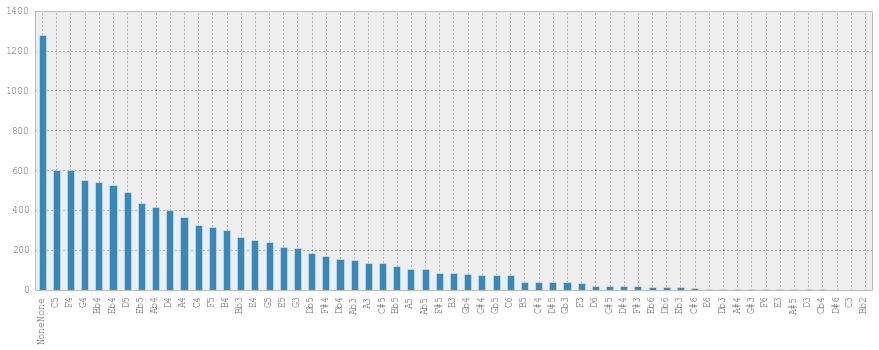

In [20]:
#df2 = df[df['noteDisplayName'] != 'NoneNone']
df['noteDisplayName'].value_counts().plot(kind="bar")

<div>At a very high level, some interesting telling things about the data, when considering that 88 notes, and it is possible that any can be played at any time, and there is no repetition. While there are 88 possible notes that Jarrett might play, the improvised solos take place across a far smaller fante. Possible to play all 88 notes of the piano keyboard, but Jarrett uses less than half of these, only 43% of the avaialble notes certainly note the case that jazz solos utilise all 38 possible notes of th piano keybaord</div>
<div>

In [21]:
#the amount of notes used in solos
len(df['midiNumber'].value_counts().values)

43

In [22]:
#the most common note used
df['midiNumber'].value_counts().values[0:10].sum()

5067

In [23]:
float(df['midiNumber'].value_counts().values[0:10].sum()) / df['restFlag'].count()

0.48800924588269284

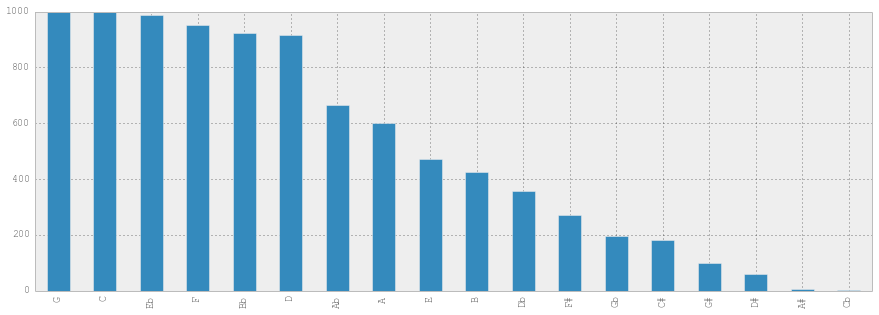

In [24]:
df2 = df[df['noteDisplayNameNoOctave'] != 'None']
df2['noteDisplayNameNoOctave'].value_counts().plot(kind="bar")


<div>Not only do the notes take place on a far smaller range(D5, F4...) account for 52% o the notes played. Even though there appears to be much variation, phrase, no repetition, possible notes all possible notes, the data suggests that leaving everything else aside, there is not as much variation extrememly limited, it is not the case, there is not as much randomness in this data</div>
<br>
<div>
   What is driving note choice, It is possible to show that Jarrett uses all twelve notes of the octave regadless of the chord. There are instances. So is there a way to show global trends in note choice?
    It is self evident to expect Jarrett uses a smaller range, limitations of the nature of right hand of the piano, the immediete questions might be to ask that if some more common than others and can any reason be found for this? But a deeper question here is whether The data-set shows that Jarrett not only utilises a limited range of the piano for solos (which is perhaps obvious), but it is not a uniform distribution. 
   In addition to examining when certain midi frequencies occur (which denote every key on the piano), it is possible to look on at the notes themselves, regardless of the octave in which they may appear. The figure below (Figure 3.x) provides a visualisation of this. The y-axis shows the count of occurrences of particular notes regardless of octave, and the x-axis lists which notes these are (a legend for this can be seen below the graph). This graph reveals that some notes (such as Eb, C, G and D) occur approximately twice as much as some other notes notes (such as B, F#, E and C#). Although Jarrett uses all 12 notes of the octave and is it possible to find the 12 notes in play during, not all of these notes are used interchangeably, and the underlying key signature of the work importany determiner</div>


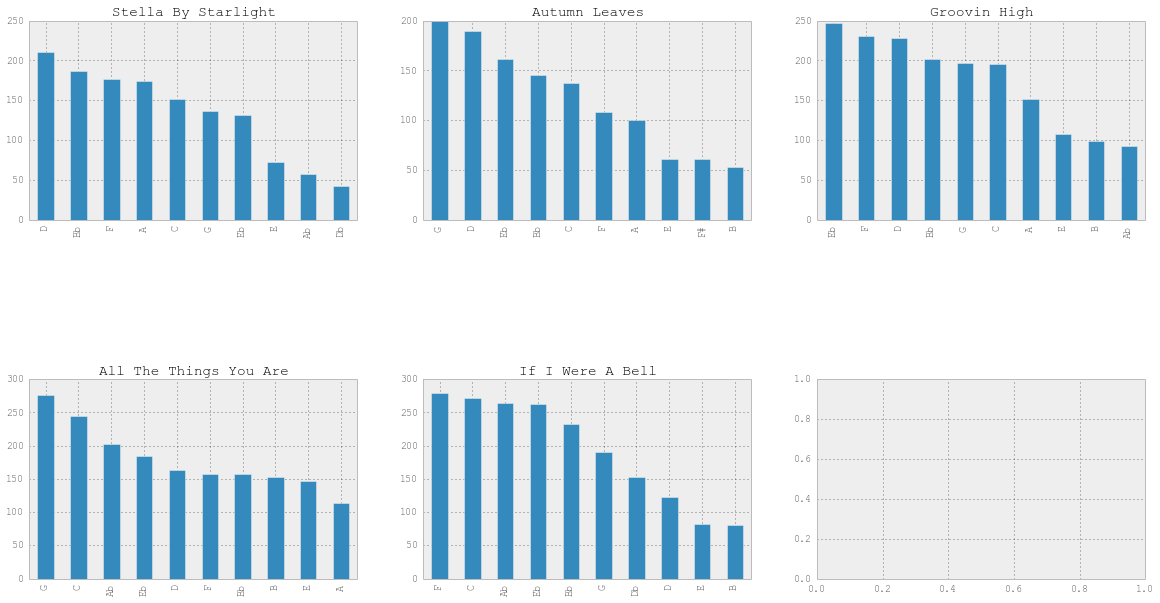

In [25]:
fig, axes = plt.subplots(nrows=2,ncols=3)

df2[df2['title'] == 'Stella By Starlight']['noteDisplayNameNoOctave'].value_counts()[0:10].plot(kind="bar", ax=axes[0,0], figsize=(20, 10), title='Stella By Starlight')
df2[df2['title'] == 'Autumn Leaves']['noteDisplayNameNoOctave'].value_counts()[0:10].plot(kind="bar", ax=axes[0,1], figsize=(20, 10), title='Autumn Leaves')
df2[df2['title'] == 'Groovin High']['noteDisplayNameNoOctave'].value_counts()[0:10].plot(kind="bar", ax=axes[0,2], figsize=(20, 10), title='Groovin High')
df2[df2['title'] == 'All The Things You Are']['noteDisplayNameNoOctave'].value_counts()[0:10].plot(kind="bar", ax=axes[1,0], figsize=(20, 10), title='All The Things You Are')
df2[df2['title'] == 'If I Were A Bell']['noteDisplayNameNoOctave'].value_counts()[0:10].plot(kind="bar", ax=axes[1,1], figsize=(20, 10), title='If I Were A Bell')
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

<div>The collorary of this to examine note choice that seldom occurs. The figure below shows

<h5>The most seldom occuring notes</h5>

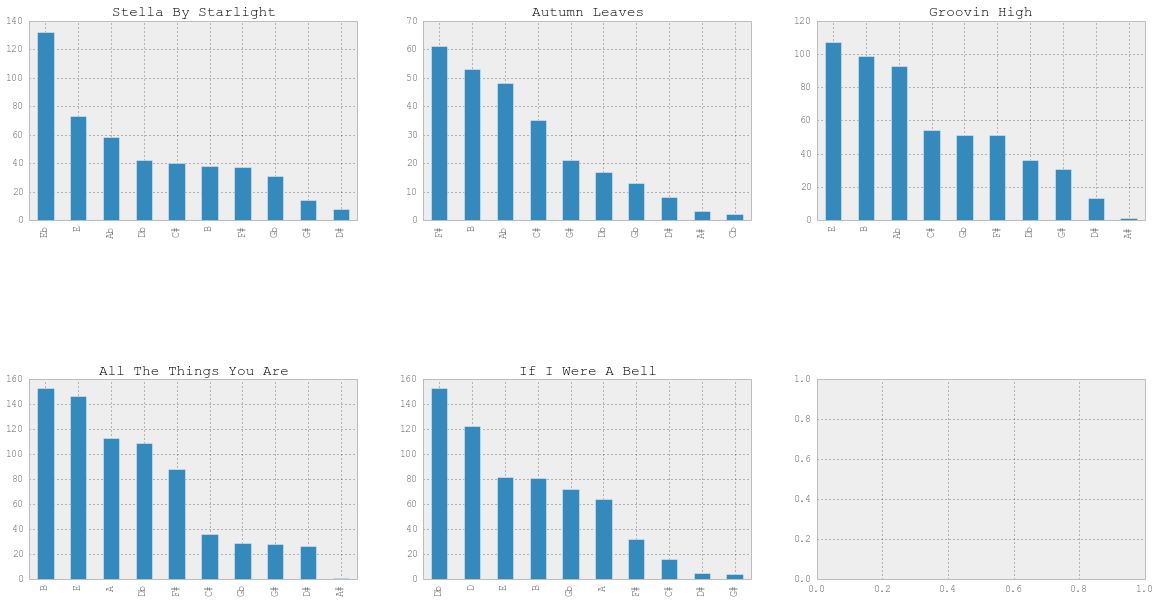

In [26]:
fig, axes = plt.subplots(nrows=2,ncols=3)

df2[df2['title'] == 'Stella By Starlight']['noteDisplayNameNoOctave'].value_counts()[-10:].plot(kind="bar", ax=axes[0,0], figsize=(20, 10), title='Stella By Starlight')
df2[df2['title'] == 'Autumn Leaves']['noteDisplayNameNoOctave'].value_counts()[-10:].plot(kind="bar", ax=axes[0,1], figsize=(20, 10), title='Autumn Leaves')
df2[df2['title'] == 'Groovin High']['noteDisplayNameNoOctave'].value_counts()[-10:].plot(kind="bar", ax=axes[0,2], figsize=(20, 10), title='Groovin High')
df2[df2['title'] == 'All The Things You Are']['noteDisplayNameNoOctave'].value_counts()[-10:].plot(kind="bar", ax=axes[1,0], figsize=(20, 10), title='All The Things You Are')
df2[df2['title'] == 'If I Were A Bell']['noteDisplayNameNoOctave'].value_counts()[-10:].plot(kind="bar", ax=axes[1,1], figsize=(20, 10), title='If I Were A Bell')
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

<p>It now becomes possible to establish the first clear link between the notes found in the solo and the notes found in the chords that form the underlying harmonic progressions and it is what can be found. The notes that are more common in the solos, are those that also are contained in the harmonic progressions of the data-set. Other notes that which do not occur as much in the solos (notes such as the B, F# and E) are seldom seen in the harmonic progressions of the data set. But the stndards under position</p>

<p>In a way, this should be obvious. It makes intuitive sense (and is often discussed in jazz instructional materials) that notes in the solo should have some kind of correlation to the notes in the harmonic progressions. However, when exploring the the data-set it quickly becomes apparent that there is a much deeper story. It is impossible to describe jazz in terms of using a particular scale.</p>

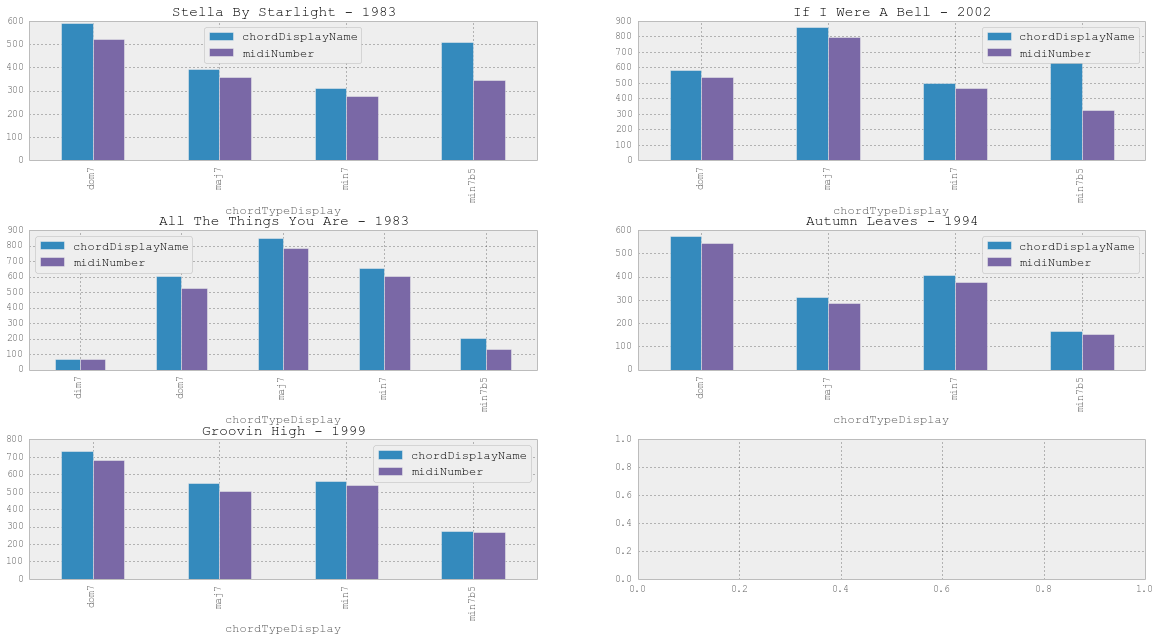

In [27]:
#df2 = df[df['title'] == 'Stella By Starlight']

fig, axes = plt.subplots(nrows=3,ncols=2)
df[df['title'] == 'Stella By Starlight'].groupby('chordTypeDisplay')['chordDisplayName', 'midiNumber'].count().plot(kind="bar", ax=axes[0,0], figsize=(20, 10), title='Stella By Starlight - 1983')
df[df['title'] == 'If I Were A Bell'].groupby('chordTypeDisplay')['chordDisplayName', 'midiNumber'].count().plot(kind="bar", ax=axes[0,1], figsize=(20, 10), title='If I Were A Bell - 2002')
df[df['title'] == 'All The Things You Are'].groupby('chordTypeDisplay')['chordDisplayName', 'midiNumber'].count().plot(kind="bar", ax=axes[1,0], figsize=(20, 10), title='All The Things You Are - 1983')
df[df['title'] == 'Autumn Leaves'].groupby('chordTypeDisplay')['chordDisplayName', 'midiNumber'].count().plot(kind="bar", ax=axes[1,1], figsize=(20, 10), title='Autumn Leaves - 1994')
df[df['title'] == 'Groovin High'].groupby('chordTypeDisplay')['chordDisplayName', 'midiNumber'].count().plot(kind="bar", ax=axes[2,0], figsize=(20, 10), title='Groovin High - 1999')


#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

<div>Although at the level of phrase, there is no repetition, there is certainly repection and prediction that can be found in this data set. For the choice of playing a note of rest, Jarrett is certainly favouring playing a note. The amount of notes is note changing, but the min7b5 chord appears to have more variabiity in what is played. There is strucure and predictability. In the next chapter covering harmony it will turn out that the if the min7b5 chord occurs as part of a II-V-I progression it will have more notes played over it, as opposed Also at this level at least, jarretts playing is not changing over a 20 year period </div>

<h4><a id="phraseLength">Phrase Length</a></h4>

In [220]:
df2 = df[df['part'] == 'P1']
rowIt = df2.iterrows()

In [221]:
theList = []
measureLocationList = []

for index, row in rowIt:
    titleAndMeasure = str(row['title']) + ', ' + ' measure ' + str(row['measure']) + ':'
    measureLocationList.append(titleAndMeasure)
    if str(row['restFlag']) == 'rest':
        theList.append(-1)
        #measureLocationList.append(row['measure'])
    else:
        theList.append(row['quarterNoteDuration'])
        #measureLocationList.append(row['measure'])
        

In [222]:
chunkedDurationArray = []
tempArray = []

for x in range(0,len(theList)):
    if len(tempArray) == 0:
        measureNumber = str(measureLocationList[x])
        
        tempArray.append(measureNumber)
    if theList[x] != -1:
        tempArray.append(theList[x])
    if theList[x] == -1:

        chunkedDurationArray.append(tempArray)
        tempArray = []
        

In [223]:
listOfPhraseLengthsAboveOne = []
measureLocation = []
for eachItem in chunkedDurationArray:
    if len(eachItem) > 2:
        listOfPhraseLengthsAboveOne.append(len(eachItem))
        measureLocation.append(eachItem[0])
#chunkedDurationArray[0:10]

In [224]:
df5 = pd.DataFrame(measureLocation, columns=['Location of Phrase'])
df5['Number of notes in phrase'] = listOfPhraseLengthsAboveOne

In [272]:
df5[df5['Location of Phrase'].str.contains('Stella')].sort(columns='Number of notes in phrase', ascending=0)[0:20]

,Location of Phrase,Number of notes in phrase
34,"Stella By Starlight, measure 73.0:",75
54,"Stella By Starlight, measure 118.0:",62
39,"Stella By Starlight, measure 83.0:",61
45,"Stella By Starlight, measure 100.0:",49
14,"Stella By Starlight, measure 30.0:",44
50,"Stella By Starlight, measure 107.0:",42
31,"Stella By Starlight, measure 64.0:",39
65,"Stella By Starlight, measure 141.0:",39
29,"Stella By Starlight, measure 58.0:",37
27,"Stella By Starlight, measure 55.0:",36


<div>
    Across the entire corpus there is a total of there are 1004 instances where notes stop and start. There are 404 phrases, which ,  These are calculated as any sequence of more than two notes. Each phrase reveals information about characteristics of pitch, melody, and occurs at a paricular location and and occurs at a particular tempo in a particular song, all of whicy can be seen as indicators. Broadly speaking, the data reveals that. It is hard to glean much information from phrase length. Phrases over 25 notes in length do occur but they are rare and they are unique
</div>

<div>Phrase length is a critical way in which to create vareity. But what is happening here. Looking at the data however, there is no sense in which phrase length is an indicator. It does not change. Further looking across the data, the length of phrase does not seemed to be determined by the position in the song. It is not possible to use phrase length to derive the likely position in the song </div>

In [259]:
#df5[df5['Location of Phrase'].str.contains('Aut')]

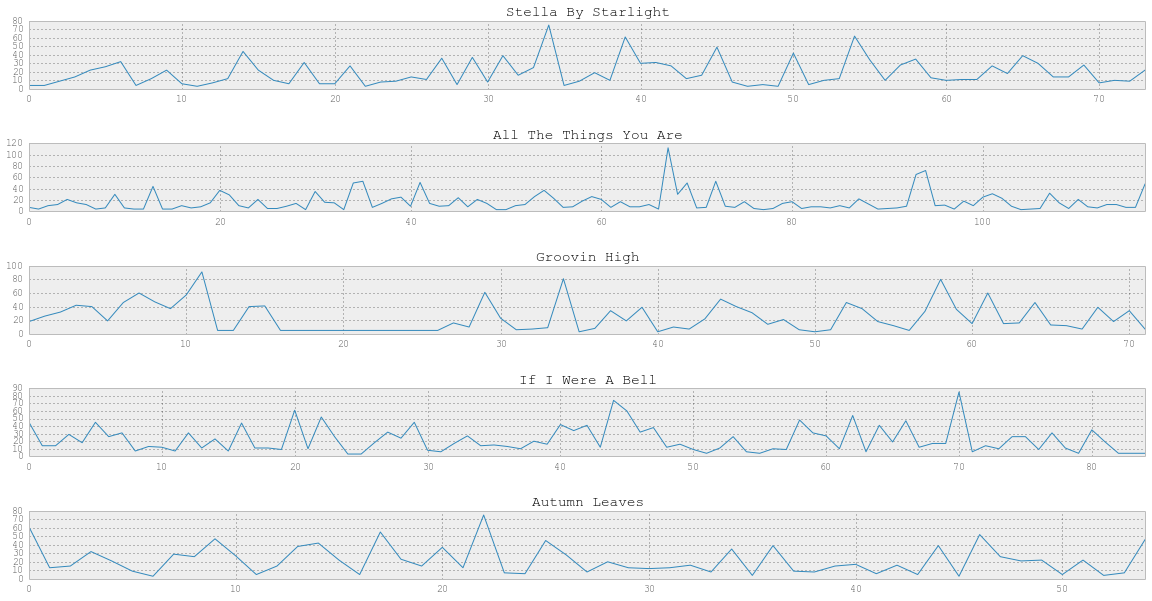

In [258]:
fig, axes = plt.subplots(nrows=5,ncols=1)

df5[df5['Location of Phrase'].str.contains('Stella')].reset_index()['Number of notes in phrase'].plot(ax=axes[0], figsize=(20, 10),title="Stella By Starlight")
df5[df5['Location of Phrase'].str.contains('All')].reset_index()['Number of notes in phrase'].plot(ax=axes[1], figsize=(20, 10),title="All The Things You Are")
df5[df5['Location of Phrase'].str.contains('Groovin')].reset_index()['Number of notes in phrase'].plot(ax=axes[2], figsize=(20, 10),title="Groovin High")
df5[df5['Location of Phrase'].str.contains('If I')].reset_index()['Number of notes in phrase'].plot(ax=axes[3], figsize=(20, 10),title="If I Were A Bell")
df5[df5['Location of Phrase'].str.contains('Aut')].reset_index()['Number of notes in phrase'].plot(ax=axes[4], figsize=(20, 10),title="Autumn Leaves")


subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots


<div>What emerges is that slow tempos tend to create more opportunities for longer phrases. All the thing you are and Stella by Starlight was recorded on the same record, however, so phrase length is not evolving. However very fast tempos seem to have less long phrases. Modern jazz improvisation, constant interaction between different sized phrases. Different musicians will have a different approach to this</div>

array([[<matplotlib.axes.AxesSubplot object at 0x112b88a10>]], dtype=object)

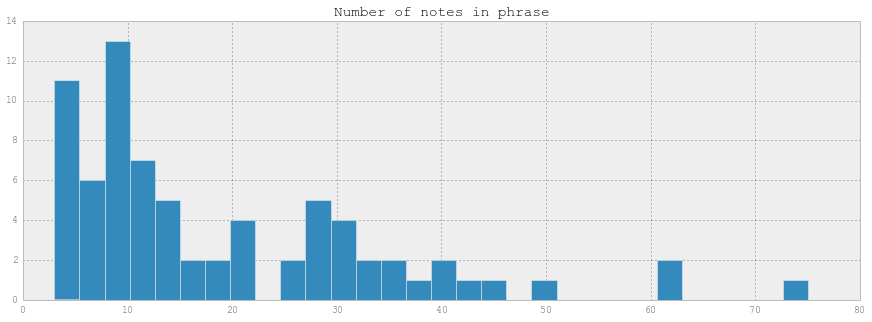

In [276]:
df5[df5['Location of Phrase'].str.contains('Stella')].hist(bins=30, column='Number of notes in phrase')

array([[<matplotlib.axes.AxesSubplot object at 0x111971650>]], dtype=object)

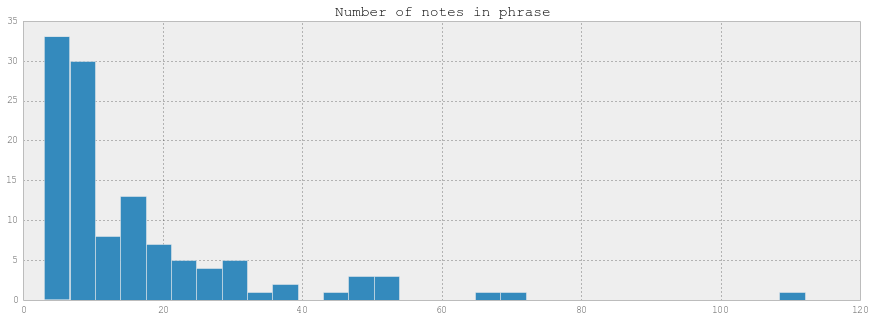

In [279]:
df5[df5['Location of Phrase'].str.contains('All')].hist(bins=30, column='Number of notes in phrase')

array([[<matplotlib.axes.AxesSubplot object at 0x10fa738d0>]], dtype=object)

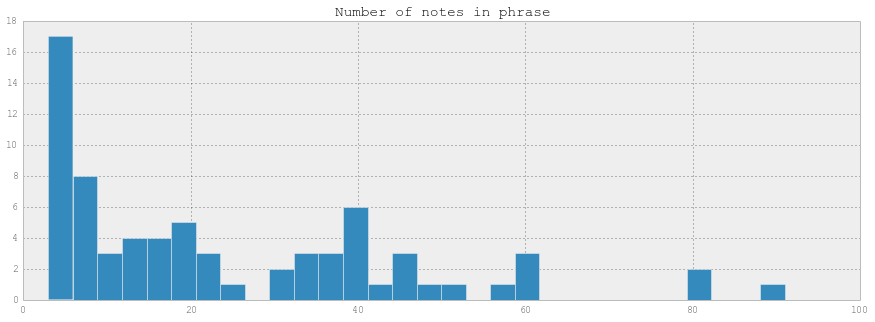

In [280]:
df5[df5['Location of Phrase'].str.contains('Groovin')].hist(bins=30, column='Number of notes in phrase')

array([[<matplotlib.axes.AxesSubplot object at 0x114010e90>]], dtype=object)

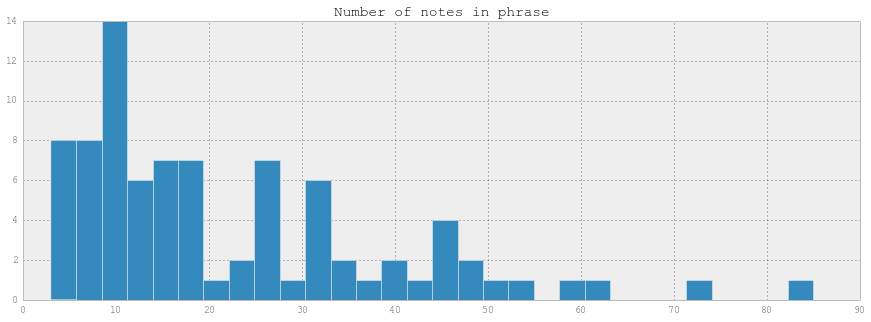

In [281]:
df5[df5['Location of Phrase'].str.contains('If I')].hist(bins=30, column='Number of notes in phrase')

array([[<matplotlib.axes.AxesSubplot object at 0x113fd5990>]], dtype=object)

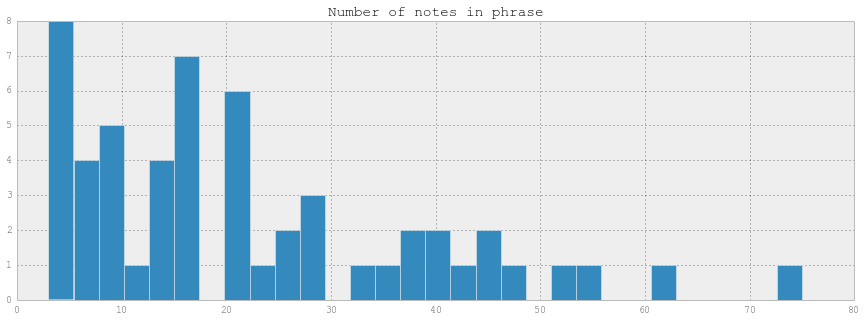

In [283]:
df5[df5['Location of Phrase'].str.contains('Aut')].hist(bins=30, column='Number of notes in phrase')

<div>Phrase length, at this level doesn't reveal a strong sty. The majority of the phrases tend to bwe between 4 nots and 20 notes, so there is a bias toward shorter phrases (3/4 of the all the melodic phrases are less than 20 notes long. There is not a tendency to use phrases of particular length outside a certaiin range, Also, the very long phrases tend to be unique in terms of the number of notes. So the longer phrases, not idiomatic, only tend to occur once in the entire corpus and are unique
</div>

<div>So what to some of these phrases actually look like?</div>

In [206]:
select = muStellaByStarlight.parts[0].measures(38,43)

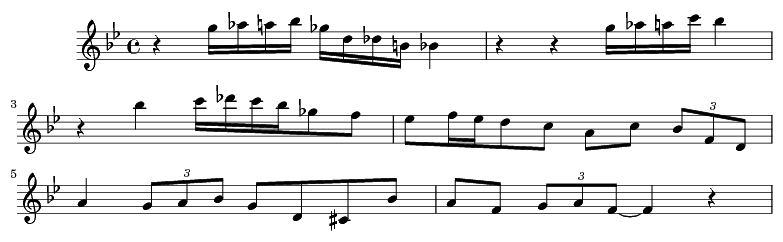

In [207]:
select.show()

In [ ]:
#for stuff in chunkedDurationArray:
 #   print len(stuff)

In [ ]:
#df[df['part'] == 'P1']['midiNumber'][0:30].plot()

<div>
    In the music of keith Jarrett
</div>

<h4><a id="microphrase">Commonly used patterns within phrases</a></h4>

<h4><a id="keySignature">The influence of key signature</a></h4>

<h4><a id="repetitionAndSequences">Repetition and sequences</a></h4>

<h4><a id="rhythm">The use of rhythm</a></h4>

<h4><a id="contour">Melodic contours</a></h4>

<h4><a id="tempo">The influence of tempo</a></h4>

<h4><a id="timeSignaure">The influence of time signature</a></h4>

<h4><a id="songLocation">How melodic phrases are affected by the place they occur</a></h4>

<span id="myid">placeholder</span>

In [ ]:
test = df['nextNoteFreqDistance'].as_matrix()

In [ ]:
B = np.array_split(test,4)

In [ ]:
B

In [ ]:
#py_.chunk(df['nextNoteFreqDistance'].values(), 3)

In [ ]:
partOneAsMatrix = df[df['part'] == 'P1']
matrix = partOneAsMatrix[['part','quarterNoteDuration','noteEventStartingLocation', 'midiNumber']].as_matrix()

In [ ]:
matrix[0:20]

In [ ]:
#create 
threeNoteSequences = []
phraseLength = 3


for x in range(len(matrix)):
    noteTuple= []
    currentNote = matrix[x][3]
    #print matrix[x]
    noteTuple.append(str(currentNote))
    #secondNote = None
    #thirdNote = None
    
    try:
        secondNote = matrix[x+1][3]
        noteTuple.append(str(secondNote))
        
    except: 
        pass
    
    try:
        thirdNote = matrix[x+2][3]
        noteTuple.append(str(thirdNote))
    except: 
        pass
    
    threeNoteSequences.append(noteTuple)
    
    


#print threeNoteSequences

In [ ]:
df2 = pd.DataFrame(threeNoteSequences, columns=['one', 'two', 'three'])

In [ ]:
df2['next'] = (df2['one'] +  df2['two'] +  df2['three'])

In [ ]:
df2

In [ ]:
df2['next'].value_counts()

In [ ]:
#df2['merged'] = str(df2[1]) + ',' + str(df2[2])

In [ ]:
#df2['merged'].value_counts()